<a href="https://colab.research.google.com/github/lauragoon/Face-Mask-Detector/blob/main/cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [4]:
def get_data(batch_size, directory):
  
  datagen = image.ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
  dta = datagen.flow_from_directory(directory, class_mode='binary', batch_size=batch_size)

  return dta

In [5]:
## generate data
train_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/training'
val_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/validation'

train_data = get_data(50, train_path)
val_data = get_data(35, val_path)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

##transfer learning with fine tuning
num_epochs = 35
steps_epoch = 100
steps_val = 50

resnet.trainable = True
for layer in resnet.layers:
    set_trainable = False
    if layer.name in ['conv5_block3_3_conv', 'conv5_block3_2_relu', 'conv5_block3_2_conv']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
# resnet.summary()

model = models.Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu', input_dim=(256,256,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])
# model.summary()

filepath = "cnn4.h5"
checkpt = ModelCheckpoint(filepath=filepath, monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
callbacks_list = [checkpt]

history = model.fit(train_data, steps_per_epoch=steps_epoch, epochs=num_epochs, validation_data=val_data, validation_steps=steps_val, callbacks = callbacks_list, verbose=1)

Found 6804 images belonging to 2 classes.
Found 1954 images belonging to 2 classes.
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/35
100/100 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5864 
Epoch 00001: val_accuracy improved from -inf to 0.74057, saving model to cnn4.h5
100/100 [==============================] - 3514s 35s/step - loss: 0.7009 - accuracy: 0.5864 - val_loss: 0.5456 - val_accuracy: 0.7406
Epoch 2/35
100/100 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.6853
Epoch 00002: val_accuracy improved from 0.74057 to 0.77714, saving model to cnn4.h5
100/100 [==============================] - 1015s 10s/step - loss: 0.5927 - accuracy: 0.6853 - val_loss: 0.5042 - val_accuracy: 0.7771
Epoch 3/35
100/100 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.7315
Epoch 00003: val_accuracy improved from 0.77714 to 0.81714, saving model to cnn4.h5
100/100 [==============================] - 51

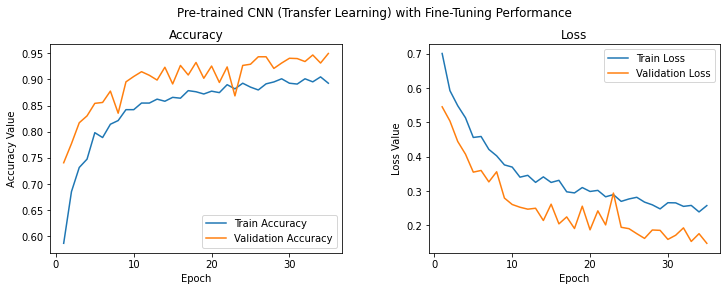

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,36))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 36, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")  

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 36, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [8]:
## code to display model results
## from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch05_Building_Tuning_and_Deploying_Models/model_evaluation_utils.py

from sklearn import metrics
import numpy as np
import pandas as pd

def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex([['Predicted:'], classes], 
                                                  level_labels), 
                            index=pd.MultiIndex([['Actual:'], classes], 
                                                level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)


def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

In [9]:
from keras.models import load_model

# cnn_model = load_model('drive/Shared drives/DSCI 303 Final Project/cnn.h5')
cnn_model = load_model('cnn4.h5')

test_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/test'
test_data = get_data(200, test_path)
test_batch_images, test_batch_class = test_data.next()

predictions = cnn_model.predict_classes(test_batch_images)

display_model_performance_metrics(true_labels=test_batch_class, predicted_labels=predictions, 
                                      classes=list(set(test_batch_class)))

Found 2228 images belonging to 2 classes.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Model Performance metrics:
------------------------------
Accuracy: 0.945
Precision: 0.9451
Recall: 0.945
F1 Score: 0.945

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       103
         1.0       0.94      0.95      0.94        97

    accuracy                           0.94       200
   macro avg       0.94      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   0.0 1.0

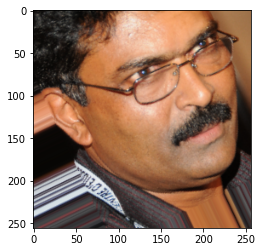

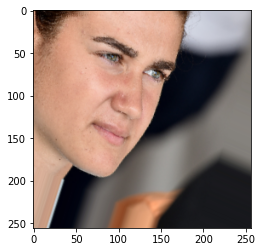

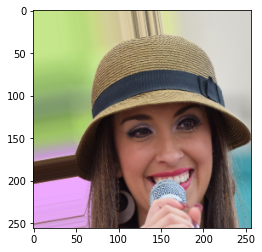

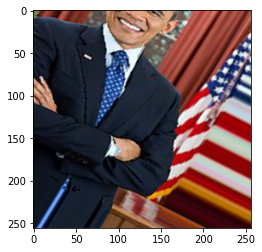

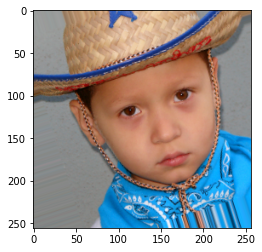

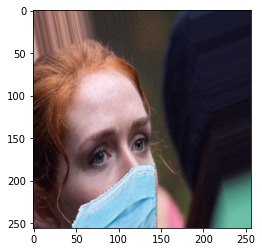

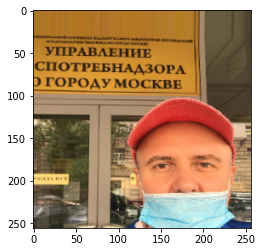

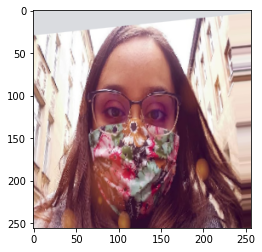

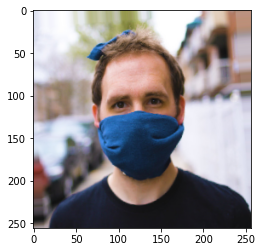

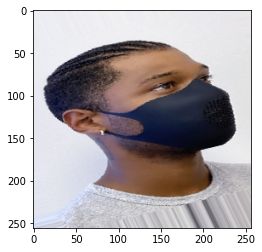

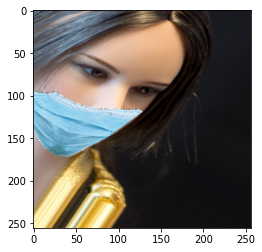

In [10]:
actual1predicted0 = [i for i in range(len(test_batch_class)) if test_batch_class[i] == 1 and predictions[i] == 0]
actual0predicted1 = [i for i in range(len(test_batch_class)) if test_batch_class[i] == 0 and predictions[i] == 1]

for i in actual1predicted0:
  plt.figure()
  plt.imshow(test_batch_images[i])

for i in actual0predicted1:
  plt.figure()
  plt.imshow(test_batch_images[i])


In [ ]:
# sources: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a; https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38